In [5]:
import nest_asyncio
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Aplicamos nest_asyncio
nest_asyncio.apply()

# Ejecutamos el notebook
%run cargue_info.ipynb

# Ahora ejecutamos la función main en este notebook
asyncio.run(main())

# Puedes acceder a la variable 'df' desde el nuevo notebook
print(df.head())

   Código Departamento Nombre Departamento  Código Municipio Nombre Municipio  \
0                    5           ANTIOQUIA              5001         MEDELLÍN   
1                    5           ANTIOQUIA              5002        ABEJORRAL   
2                    5           ANTIOQUIA              5004         ABRIAQUÍ   
3                    5           ANTIOQUIA              5021       ALEJANDRÍA   
4                    5           ANTIOQUIA              5030            AMAGÁ   

  Tipo: Municipio / Isla / Área no municipalizada    longitud   Latitud  
0                                       Municipio  -75,581775  6,246631  
1                                       Municipio  -75,428739  5,789315  
2                                       Municipio  -76,064304  6,632282  
3                                       Municipio  -75,141346  6,376061  
4                                       Municipio  -75,702188  6,038708  
   Código Departamento Nombre Departamento  Código Municipio Nombre M

In [6]:
df_municipios = df.copy()
df_base = base.copy()

In [ ]:
df_base.shape

In [ ]:
df_municipios.shape

In [ ]:
df_base.columns

In [ ]:
df_municipios.columns

In [ ]:
#Describe operaciones basicas en los campos numericos
df_base.describe

In [ ]:
df_municipios.describe

In [7]:
import unicodedata
def quitar_tildes(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Quitar tildes de los nombres de las columnas
df_municipios.columns = [quitar_tildes(col) for col in df.columns]

In [8]:
df_municipios.rename(columns={'Codigo Municipio': 'Codigo_Municipio'}, inplace=True)

In [ ]:
#Primeros 5 registros
df_base.head

In [ ]:
df_municipios.head

In [ ]:
df_base.isnull().sum()

In [ ]:
df_municipios.isnull().sum()

In [ ]:
df_base

In [ ]:
df_municipios

In [9]:
Tabla_dep = pd.merge(df_base,df_municipios, how='right', on = 'Codigo_Municipio')
Tabla_dep

,Unnamed: 0,Tipo_Entidad,Nombre_Tipo_Entidad,Codigo_Entidad,Nombre_Entidad,Fecha_Corte,Tipo_de_persona,Sexo,Tamaño_de_empresa,Tipo_de_crédito,...,Rango_monto_desembolsado,Clase_deudor,Codigo_CIIU,Codigo_Municipio,Codigo Departamento,Nombre Departamento,Nombre Municipio,Tipo: Municipio / Isla / Area no municipalizada,longitud,Latitud
0,686.0,1.0,BC-ESTABLECIMIENTO BANCARIO,6.0,Itaú,22/12/2023,Natural,Masculino,No aplica,Consumo,...,Mayor a 6 SMLMV menor o igual a 12 SMLMV,Deudor de la entidad,6910.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
1,1319.0,1.0,BC-ESTABLECIMIENTO BANCARIO,39.0,Banco Davivienda,29/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,6920.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
2,1683.0,4.0,CF-COMPAÑÍA DE FINANCIAMIENTO,26.0,Tuya,01/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,9609.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
3,1901.0,4.0,CF-COMPAÑÍA DE FINANCIAMIENTO,26.0,Tuya,01/12/2023,Natural,Femenino,No aplica,Consumo,...,Mayor a 1 SMLMV menor o igual a 3 SMLMV,Deudor de la entidad,6531.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
4,2018.0,4.0,CF-COMPAÑÍA DE FINANCIAMIENTO,26.0,Tuya,08/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,4651.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340178,40359068.0,1.0,BC-ESTABLECIMIENTO BANCARIO,1.0,Banco de Bogotá,08/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor nuevo en la entidad,10.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"
5340179,40603073.0,1.0,BC-ESTABLECIMIENTO BANCARIO,7.0,Bancolombia,01/12/2023,Jurídica,No aplica,Microempresa,Comercial ordinario,...,Hasta 1 SMLMV,Deudor de la entidad,9319.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"
5340180,40728936.0,1.0,BC-ESTABLECIMIENTO BANCARIO,43.0,Banagrario,15/12/2023,Natural,Masculino,Microempresa,Crédito productivo,...,Mayor a 1 SMLMV y menor o igual a 2 SMLMV,Deudor nuevo en la entidad,150.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"
5340181,40755754.0,1.0,BC-ESTABLECIMIENTO BANCARIO,7.0,Bancolombia,01/12/2023,Natural,Femenino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,10.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"


In [ ]:
Tabla_dep.columns

In [ ]:
Tabla_dep['Fecha_Corte'] 

In [ ]:
Tabla_dep['Fecha_Corte'] = pd.to_datetime(Tabla_dep['Fecha_Corte'])

In [ ]:
# 1. Análisis de Tendencias Temporales
# Agrupar por Fecha_Corte y sumar Montos_desembolsados
tendencias_temporales = Tabla_dep.groupby('Fecha_Corte')['Montos_desembolsados'].sum()

plt.figure(figsize=(10, 5))
plt.plot(tendencias_temporales, marker='o')
plt.title('Tendencias Temporales de Montos Desembolsados')
plt.xlabel('Fecha')
plt.ylabel('Montos Desembolsados')
plt.grid(True)
plt.show()



In [ ]:
# 2. Análisis Geoespacial
plt.figure(figsize=(10, 5))
sns.scatterplot(data=Tabla_dep, x='longitud', y='Latitud', hue='Montos_desembolsados', palette='viridis', size='Montos_desembolsados', sizes=(20, 200))
plt.title('Mapa de Desembolsos de Crédito')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Montos Desembolsados', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [14]:
Tabla_dep['Montos_desembolsados'].dtype

dtype('O')

In [10]:
# 3. Análisis de Correlación
correlaciones = Tabla_dep[['Montos_desembolsados', 'Numero_de_creditos_desembolsados', 'Tasa_efectiva_promedio_ponderada', 'margen_adicional']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()



ValueError: could not convert string to float: '9,000,000'

In [16]:
# 4. Análisis de Segmentación
# Seleccionar variables para el análisis de cluster
variables_cluster = Tabla_dep[['Montos_desembolsados', 'Numero_de_creditos_desembolsados', 'Tasa_efectiva_promedio_ponderada']].dropna()
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(variables_cluster)
Tabla_dep['Cluster'] = clusters

plt.figure(figsize=(10, 5))
sns.scatterplot(data=Tabla_dep, x='Montos_desembolsados', y='Numero_de_creditos_desembolsados', hue='Cluster', palette='viridis')
plt.title('Segmentación de Créditos por Clusters')
plt.xlabel('Montos Desembolsados')
plt.ylabel('Número de Créditos Desembolsados')
plt.show()



NameError: name 'KMeans' is not defined

In [ ]:
# 5. Análisis de Riesgo
# Simplificado: calculando la tasa de incumplimiento aproximada si existiera una columna 'Incumplimiento'
# Tabla_dep['Tasa_Incumplimiento'] = Tabla_dep['Incumplimiento'] / Tabla_dep['Numero_de_creditos_desembolsados']

In [22]:
Tabla_dep

,Unnamed: 0,Tipo_Entidad,Nombre_Tipo_Entidad,Codigo_Entidad,Nombre_Entidad,Fecha_Corte,Tipo_de_persona,Sexo,Tamaño_de_empresa,Tipo_de_crédito,...,Rango_monto_desembolsado,Clase_deudor,Codigo_CIIU,Codigo_Municipio,Codigo Departamento,Nombre Departamento,Nombre Municipio,Tipo: Municipio / Isla / Area no municipalizada,longitud,Latitud
0,686.0,1.0,BC-ESTABLECIMIENTO BANCARIO,6.0,Itaú,22/12/2023,Natural,Masculino,No aplica,Consumo,...,Mayor a 6 SMLMV menor o igual a 12 SMLMV,Deudor de la entidad,6910.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
1,1319.0,1.0,BC-ESTABLECIMIENTO BANCARIO,39.0,Banco Davivienda,29/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,6920.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
2,1683.0,4.0,CF-COMPAÑÍA DE FINANCIAMIENTO,26.0,Tuya,01/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,9609.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
3,1901.0,4.0,CF-COMPAÑÍA DE FINANCIAMIENTO,26.0,Tuya,01/12/2023,Natural,Femenino,No aplica,Consumo,...,Mayor a 1 SMLMV menor o igual a 3 SMLMV,Deudor de la entidad,6531.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
4,2018.0,4.0,CF-COMPAÑÍA DE FINANCIAMIENTO,26.0,Tuya,08/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,4651.0,5001.0,5,ANTIOQUIA,MEDELLÍN,Municipio,"-75,581775","6,246631"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340178,40359068.0,1.0,BC-ESTABLECIMIENTO BANCARIO,1.0,Banco de Bogotá,08/12/2023,Natural,Masculino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor nuevo en la entidad,10.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"
5340179,40603073.0,1.0,BC-ESTABLECIMIENTO BANCARIO,7.0,Bancolombia,01/12/2023,Jurídica,No aplica,Microempresa,Comercial ordinario,...,Hasta 1 SMLMV,Deudor de la entidad,9319.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"
5340180,40728936.0,1.0,BC-ESTABLECIMIENTO BANCARIO,43.0,Banagrario,15/12/2023,Natural,Masculino,Microempresa,Crédito productivo,...,Mayor a 1 SMLMV y menor o igual a 2 SMLMV,Deudor nuevo en la entidad,150.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"
5340181,40755754.0,1.0,BC-ESTABLECIMIENTO BANCARIO,7.0,Bancolombia,01/12/2023,Natural,Femenino,No aplica,Consumo,...,Hasta 1 SMLMV,Deudor de la entidad,10.0,99773.0,99,VICHADA,CUMARIBO,Municipio,"-69,795533","4,446352"


In [20]:
Tabla_dep['Tipo_Entidad']

0          1.0
1          1.0
2          4.0
3          4.0
4          4.0
          ... 
5340178    1.0
5340179    1.0
5340180    1.0
5340181    1.0
5340182    1.0
Name: Tipo_Entidad, Length: 5340183, dtype: float64

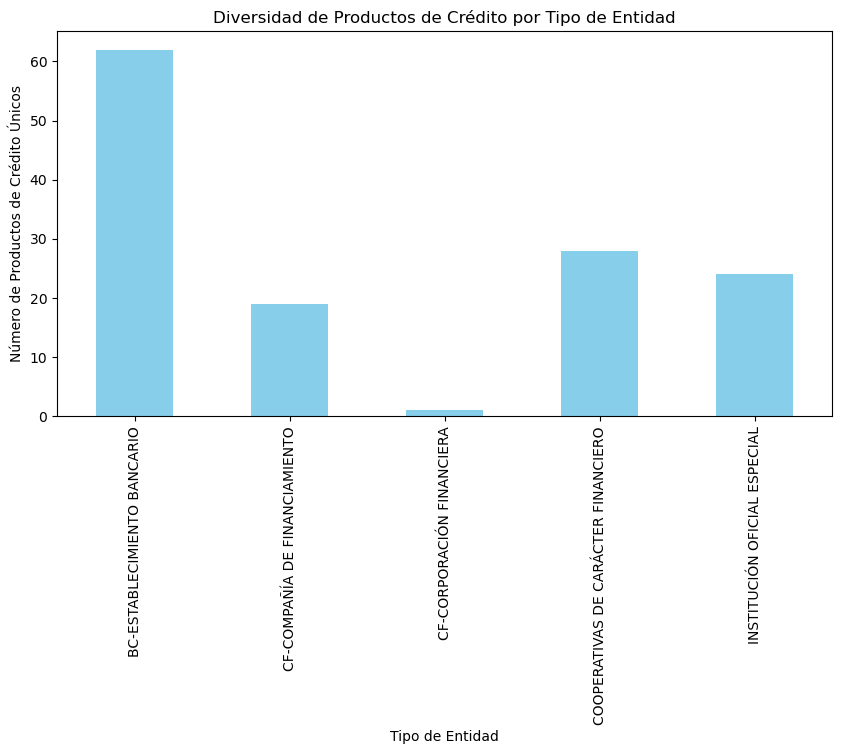

In [24]:
# 6. Análisis de Diversidad
# Diversidad de productos de crédito por tipo de entidad
productos_por_tipo_entidad = Tabla_dep.groupby('Nombre_Tipo_Entidad')['Producto de crédito'].nunique()

plt.figure(figsize=(10, 5))
productos_por_tipo_entidad.plot(kind='bar', color='skyblue')
plt.title('Diversidad de Productos de Crédito por Tipo de Entidad')
plt.xlabel('Tipo de Entidad')
plt.ylabel('Número de Productos de Crédito Únicos')
plt.show()

Oportunidades de mejora
- Un try catch para validar la disponibilidad de la pagina para descarga - Revisar codigo de Melissa
- Validar y almacenar los notebook para guardar como funciones y guardarlo con extensión py para extraer la data.
- Realizar el análisis descriptivo de la data - En proceso
- Validar cual va a ser el procedimiento y definir el paso a paso   
**2.** Archivo de Excel que contenga las siguientes tablas:  
     **-** Cantidad de desembolsos realizados por cada entidad financiera por cada tipo de crédito. - M  
     **-** Cantidad de desembolsos realizados por entidad financiera de acuerdo al sexo.  - J
     **-** Top 7 de municipios con mayor número de desembolsos.  - M
     **-** Top 7 de municipios con menor número de desembolsos.  - M   
     **-** Cantidad de desembolsos realizados por la entidad en función del rango del desembolso.     - J
     **-** Top 10 de municipios con mayor número de desembolsos desagregados por Sexo. - J
  